In [57]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.gofplots import qqplot
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.api import VAR
from tqdm import tqdm_notebook
from itertools import product
from scipy import stats

import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import math

import warnings
warnings.filterwarnings("ignore")

# Dataset

In [32]:
macro_data = pd.read_csv('DF_AEEF_trimestrali_VARMA.csv', sep=';', parse_dates=['Date'], index_col='Date')
print(macro_data.shape)
macro_data = macro_data.dropna()
macro_data

(122, 11)


,FED_RATE,TBIMTOT,Export,CPI YoY,USURTOT,GDP QoQ,Corelogic Case-Shiller,S&P500,CICRTOT,EURUSD,CONSSENT
Date,,,,,,,,,,,
1993-06-30,3.00,50758.3,37933.9,3.0,7.1,2.3,77.52,450.53,4.053,1.1729,81.5
1993-09-30,3.00,51743.0,37254.6,2.7,6.8,1.9,78.20,458.93,6.367,1.1892,77.9
1993-12-31,3.00,49347.8,40707.2,2.7,6.6,5.6,78.11,466.45,9.127,1.1244,88.2
1994-03-31,3.50,55783.0,45365.3,2.5,6.6,3.9,78.35,445.77,10.980,1.1737,91.5
1994-06-30,4.25,57348.0,42603.0,2.5,6.2,5.5,79.70,444.27,11.352,1.2238,91.2
...,...,...,...,...,...,...,...,...,...,...,...
2022-09-30,3.25,278084.0,178791.0,8.2,3.5,2.7,300.50,3585.62,27.563,0.9802,58.6
2022-12-30,4.50,255169.0,169847.0,6.5,3.6,2.6,294.42,3839.50,19.355,1.0705,59.8
2023-03-31,5.00,265309.0,187936.0,5.0,3.5,2.2,297.32,4109.31,19.665,1.0839,62.0


# Augmented Dickey Fuller Test

In [33]:
def adf_test(column):
    result = adfuller(column)
    return result[1]  

p_values = macro_data.apply(adf_test)

print("P-value per ciascuna colonna:")
print(p_values)

P-value per ciascuna colonna:
FED_RATE                  1.620332e-01
TBIMTOT                   9.646914e-01
Export                    9.654705e-01
CPI YoY                   2.071414e-01
USURTOT                   2.850778e-02
GDP QoQ                   2.528118e-24
Corelogic Case-Shiller    9.867535e-01
S&P500                    9.989241e-01
CICRTOT                   1.592831e-02
EURUSD                    2.869590e-01
CONSSENT                  4.479450e-01
dtype: float64


Sostituisco tutte le variabili per le quali non posso rigettare l'ipotesi nulla, con la loro differenza prima.

In [34]:
def adf_test(column):
    result = adfuller(column)
    return result[1] 

colonne_da_rimuovere = []

for col in macro_data.columns:
    p_value = adf_test(macro_data[col])

    if p_value > 0.05:
        colonne_da_rimuovere.append(col)
        macro_data[col + '_diff'] = macro_data[col].diff()

df_diff = macro_data.drop(colonne_da_rimuovere, axis=1)
df_diff = df_diff.dropna()
print(df_diff)

            USURTOT  GDP QoQ  CICRTOT  FED_RATE_diff  TBIMTOT_diff  \
Date                                                                 
1993-09-30      6.8      1.9    6.367           0.00         984.7   
1993-12-31      6.6      5.6    9.127           0.00       -2395.2   
1994-03-31      6.6      3.9   10.980           0.50        6435.2   
1994-06-30      6.2      5.5   11.352           0.75        1565.0   
1994-09-30      6.0      2.4   12.572           0.50        1758.0   
...             ...      ...      ...            ...           ...   
2022-09-30      3.5      2.7   27.563           1.50      -10767.0   
2022-12-30      3.6      2.6   19.355           1.25      -22915.0   
2023-03-31      3.5      2.2   19.665           0.50       10140.0   
2023-06-30      3.5      2.1   12.898           0.25       -5389.0   
2023-09-29      3.7      4.9    9.057           0.25        3838.0   

            Export_diff  CPI YoY_diff  Corelogic Case-Shiller_diff  \
Date               

In [35]:
colonne_da_rimuovere = []

for col in df_diff.columns:
    p_value = adf_test(df_diff[col])

    if p_value > 0.05:
        colonne_da_rimuovere.append(col)
        df_diff[col + '*2'] = df_diff[col].diff()

df_diff = df_diff.drop(colonne_da_rimuovere, axis=1)
df_diff = df_diff.dropna()
print(df_diff)

            USURTOT  GDP QoQ  CICRTOT  FED_RATE_diff  TBIMTOT_diff  \
Date                                                                 
1993-12-31      6.6      5.6    9.127           0.00       -2395.2   
1994-03-31      6.6      3.9   10.980           0.50        6435.2   
1994-06-30      6.2      5.5   11.352           0.75        1565.0   
1994-09-30      6.0      2.4   12.572           0.50        1758.0   
1994-12-30      5.6      4.7   15.876           0.75       -1311.0   
...             ...      ...      ...            ...           ...   
2022-09-30      3.5      2.7   27.563           1.50      -10767.0   
2022-12-30      3.6      2.6   19.355           1.25      -22915.0   
2023-03-31      3.5      2.2   19.665           0.50       10140.0   
2023-06-30      3.5      2.1   12.898           0.25       -5389.0   
2023-09-29      3.7      4.9    9.057           0.25        3838.0   

            Export_diff  CPI YoY_diff  S&P500_diff  EURUSD_diff  \
Date                  

Dopo aver differenziato tutte le serie storiche con p-value > 0,05 effettuo un nuovo ADF Test

In [36]:
def adf_test(column):
    result = adfuller(column)
    return result[1] 

p_values = df_diff.apply(adf_test)

print("P-value per ciascuna colonna:")
print(p_values)

P-value per ciascuna colonna:
USURTOT                          3.214253e-02
GDP QoQ                          3.931061e-24
CICRTOT                          1.812551e-02
FED_RATE_diff                    1.528246e-04
TBIMTOT_diff                     1.037356e-06
Export_diff                      2.641736e-03
CPI YoY_diff                     4.073153e-05
S&P500_diff                      2.162084e-02
EURUSD_diff                      6.644743e-19
CONSSENT_diff                    9.002242e-27
Corelogic Case-Shiller_diff*2    3.185470e-03
dtype: float64


Eseguo il Plot di tutte le colonne

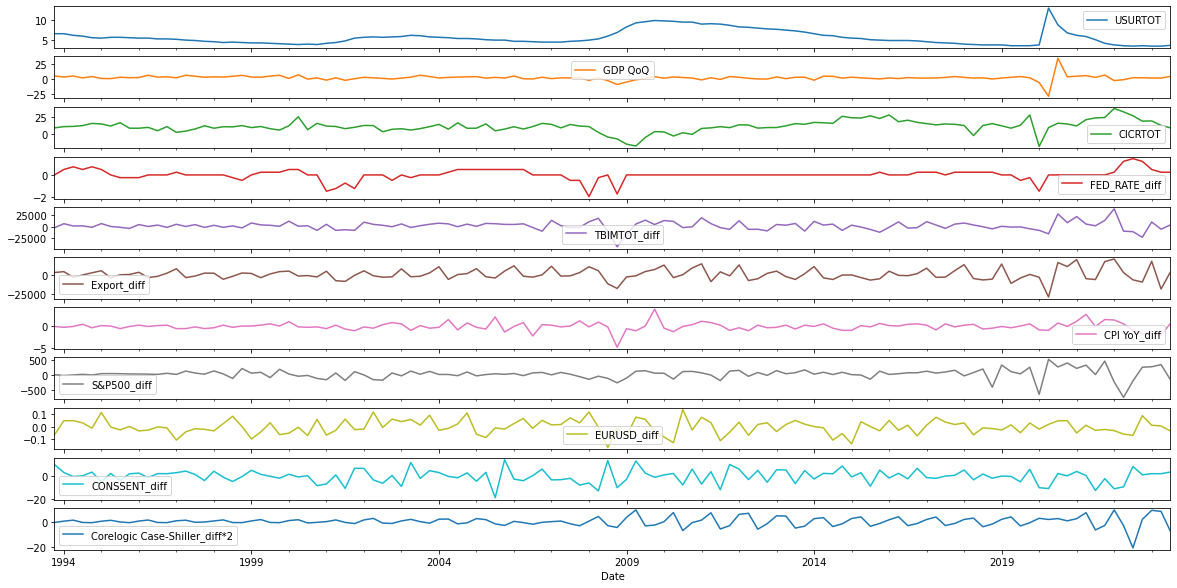

In [37]:
df_diff.plot(subplots=True, figsize=(20, 10))
plt.show()



# Matrice delle correlazioni e Multicollinearità

Stampo la matrice delle correllazioni tra le variabili

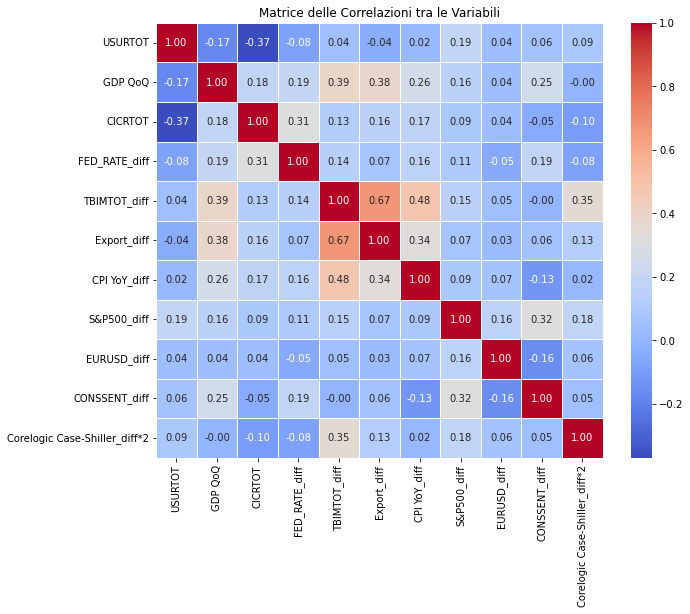

In [38]:
correlation_matrix = df_diff.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',  fmt=".2f", linewidths=.5)
plt.title('Matrice delle Correlazioni tra le Variabili')
plt.show()

Calcolo il Variance Inflation Factor escludendo dal dataset tutte le variabili con un VIF maggiore a 5

In [39]:
def calculate_vif(data_frame):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data_frame.columns
    vif_data["VIF"] = [variance_inflation_factor(data_frame.values, i) for i in range(data_frame.shape[1])]
    return vif_data

def drop_high_vif_variables(df_diff, threshold):
    vif_data = calculate_vif(df_diff)

    while vif_data['VIF'].max() > threshold:
        variable_to_drop = vif_data.loc[vif_data['VIF'].idxmax(), 'Variable']
        df_diff = df_diff.drop(variable_to_drop, axis=1)
        vif_data = calculate_vif(df_diff)
    return df_diff

vif_threshold = 5
X = drop_high_vif_variables(df_diff, vif_threshold)
print(calculate_vif(X))


                         Variable       VIF
0                         USURTOT  2.113281
1                         GDP QoQ  1.738364
2                         CICRTOT  2.343370
3                   FED_RATE_diff  1.205311
4                    TBIMTOT_diff  2.731596
5                     Export_diff  1.993667
6                    CPI YoY_diff  1.408779
7                     S&P500_diff  1.317867
8                     EURUSD_diff  1.090321
9                   CONSSENT_diff  1.375577
10  Corelogic Case-Shiller_diff*2  1.292041


# Granger Causality test

In [40]:
print('USURTOT cuases il FED_RATE_differenziata?')
granger_1 = grangercausalitytests(df_diff[['USURTOT','FED_RATE_diff']],3) #se il p-value viene <0.5 allora UNRATE causa GDP

print('\n----------------\n')
print('GDP QoQ cuases il FED_RATE_differenziata?')
granger_1 = grangercausalitytests(df_diff[['GDP QoQ','FED_RATE_diff']],3)

print('\n----------------\n')
print('CICRTOT cuases il FED_RATE_differenziata?')
granger_1 = grangercausalitytests(df_diff[['CICRTOT','FED_RATE_diff']],3)

print('\n----------------\n')
print('TBIMTOT_differenziata cuases il FED_RATE_differenziata?')
granger_1 = grangercausalitytests(df_diff[['TBIMTOT_diff','FED_RATE_diff']],3)

print('\n----------------\n')
print('Export_differenziata cuases il FED_RATE_differenziata?')
granger_1 = grangercausalitytests(df_diff[['Export_diff','FED_RATE_diff']],3)

print('\n----------------\n')
print('CPI YoY_differenziata cuases il FED_RATE_differenziata?')
granger_1 = grangercausalitytests(df_diff[['CPI YoY_diff','FED_RATE_diff']],3)

print('\n----------------\n')
print('Corelogic Case-Shiller_diff*2 cuases il FED_RATE_differenziata?')
granger_1 = grangercausalitytests(df_diff[['Corelogic Case-Shiller_diff*2','FED_RATE_diff']],3)

print('\n----------------\n')
print('S&P500_differenziata cuases il FED_RATE_differenziata?')
granger_1 = grangercausalitytests(df_diff[['S&P500_diff','FED_RATE_diff']],3)

print('\n----------------\n')
print('EURUSD_differenziata cuases il FED_RATE_differenziata?')
granger_1 = grangercausalitytests(df_diff[['EURUSD_diff','FED_RATE_diff']],3)

print('\n----------------\n')
print('CONSSENT_differenziata cuases il FED_RATE_differenziata?')
granger_1 = grangercausalitytests(df_diff[['CONSSENT_diff','FED_RATE_diff']],3)


USURTOT cuases il FED_RATE_differenziata?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=20.6805 , p=0.0000  , df_denom=116, df_num=1
ssr based chi2 test:   chi2=21.2153 , p=0.0000  , df=1
likelihood ratio test: chi2=19.5227 , p=0.0000  , df=1
parameter F test:         F=20.6805 , p=0.0000  , df_denom=116, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.3036 , p=0.0000  , df_denom=113, df_num=2
ssr based chi2 test:   chi2=23.6075 , p=0.0000  , df=2
likelihood ratio test: chi2=21.5202 , p=0.0000  , df=2
parameter F test:         F=11.3036 , p=0.0000  , df_denom=113, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.0631  , p=0.0001  , df_denom=110, df_num=3
ssr based chi2 test:   chi2=25.7287 , p=0.0000  , df=3
likelihood ratio test: chi2=23.2563 , p=0.0000  , df=3
parameter F test:         F=8.0631  , p=0.0001  , df_denom=110, df_num=3

----------------

GDP QoQ cuases il FED_RATE_differ

Creo un nuovo dataframe contenente solo le variabili che granger causano FED_RATE_diff

In [41]:
df_finale = df_diff[['FED_RATE_diff','USURTOT','GDP QoQ','CONSSENT_diff']]
df_finale

,FED_RATE_diff,USURTOT,GDP QoQ,CONSSENT_diff
Date,,,,
1993-12-31,0.00,6.6,5.6,10.3
1994-03-31,0.50,6.6,3.9,3.3
1994-06-30,0.75,6.2,5.5,-0.3
1994-09-30,0.50,6.0,2.4,0.3
1994-12-30,0.75,5.6,4.7,3.6
...,...,...,...,...
2022-09-30,1.50,3.5,2.7,8.6
2022-12-30,1.25,3.6,2.6,1.2
2023-03-31,0.50,3.5,2.2,2.2


Stampo la matrice delle correlazioni tra le 4 variabili rimaste

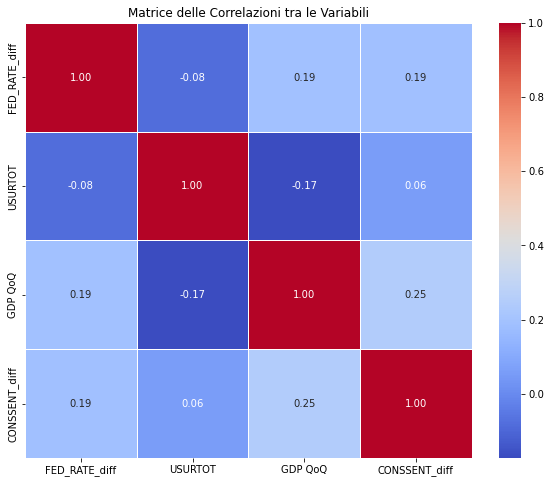

In [42]:
correlation_matrix = df_finale.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',  fmt=".2f", linewidths=.5)
plt.title('Matrice delle Correlazioni tra le Variabili')
plt.show()

Calcolo nuovamente il Variance Inflation Factor tra le variabili rimaste, ed elimino quelle con VIF maggiore a 5

In [43]:
def calculate_vif(data_frame):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data_frame.columns
    vif_data["VIF"] = [variance_inflation_factor(data_frame.values, i) for i in range(data_frame.shape[1])]
    return vif_data

def drop_high_vif_variables(df_finale, threshold):
    vif_data = calculate_vif(df_finale)

    while vif_data['VIF'].max() > threshold:
        variable_to_drop = vif_data.loc[vif_data['VIF'].idxmax(), 'Variable']
        df_finale = df_finale.drop(variable_to_drop, axis=1)
        vif_data = calculate_vif(df_diff)
    return df_diff

vif_threshold = 5
X = drop_high_vif_variables(df_finale, vif_threshold)
print(calculate_vif(df_finale))


        Variable       VIF
0  FED_RATE_diff  1.064855
1        USURTOT  1.224247
2        GDP QoQ  1.312608
3  CONSSENT_diff  1.078239


Stampo i grafici delle 4 variabili

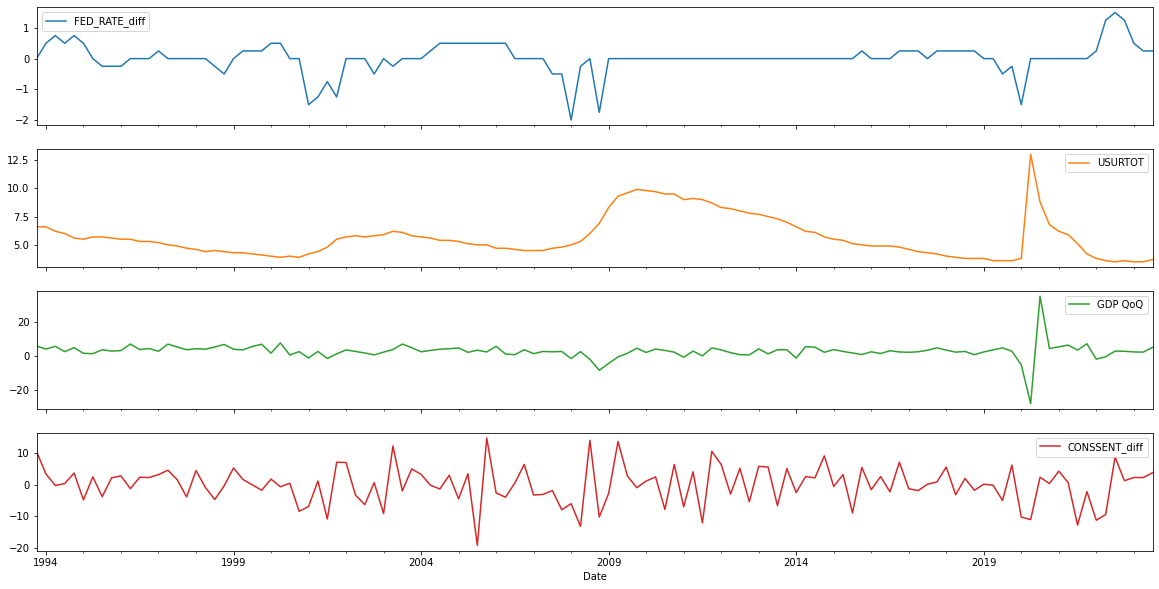

In [44]:
df_finale.plot(subplots=True, figsize=(20, 10))

plt.show()

Suddivido il dataframe in due parti, train_df e test_df, per effettuare backtest

In [45]:
train_df = df_finale[:]
test_df = df_finale[:]
print(train_df)
print('------')
print(test_df.describe())

            FED_RATE_diff  USURTOT  GDP QoQ  CONSSENT_diff
Date                                                      
1993-12-31           0.00      6.6      5.6           10.3
1994-03-31           0.50      6.6      3.9            3.3
1994-06-30           0.75      6.2      5.5           -0.3
1994-09-30           0.50      6.0      2.4            0.3
1994-12-30           0.75      5.6      4.7            3.6
...                   ...      ...      ...            ...
2022-09-30           1.50      3.5      2.7            8.6
2022-12-30           1.25      3.6      2.6            1.2
2023-03-31           0.50      3.5      2.2            2.2
2023-06-30           0.25      3.5      2.1            2.2
2023-09-29           0.25      3.7      4.9            3.7

[120 rows x 4 columns]
------
       FED_RATE_diff     USURTOT     GDP QoQ  CONSSENT_diff
count     120.000000  120.000000  120.000000     120.000000
mean        0.020833    5.658333    2.620833      -0.083333
std         0.484620  

# Criteri di selezione

Criterio di selezione del miglior VARMA sulla base del minore MSE

In [37]:
import itertools

p_values = [0,1,2,3]
q_values = [0,1,2,3]

best_mse = float(10000)
best_order = None

for p, q in itertools.product(p_values, q_values):
    try:
        model = VARMAX(train_df, order=(p, q))
        results = model.fit()
        n_forecast = 4 
        predict = results.get_prediction(start=len(train_df), end=len(train_df) + n_forecast - 1)
        predictions = predict.predicted_mean
        from sklearn.metrics import mean_squared_error

        mse = mean_squared_error(test_df['FED_RATE_diff'], predictions['FED_RATE_diff'])
        if mse < best_mse:
            best_mse = mse
            best_order = (p, q)
    except:
        continue    

print(f"Best MSE: {best_mse}")
print(f"Best Order: {best_order}")

Best MSE: 0.04875235942256946
Best Order: (3, 1)


Criterio di selezione del miglior VARMA sulla base del minor AIC

In [161]:
import pandas as pd
from statsmodels.tsa.statespace.varmax import VARMAX
import itertools

p_values = [0,1,2,3]
q_values = [0,1,2,3]

best_aic = float('inf')
best_order = None

for p, q in itertools.product(p_values, q_values):
    try:
        model = VARMAX(train_df, order=(p, q))
        results = model.fit()
        aic = results.aic
        if aic < best_aic:
            best_aic = aic
            best_order = (p, q)
    except:
        continue

print(f"Best AIC: {best_aic}")
print(f"Best Order: {best_order}")

Best AIC: 1727.637602559446
Best Order: (2, 0)


Criterio di selezione del miglior VAR dulla base di AIC, BIC, FPE, HQIC

In [46]:
model = VAR(train_df)
sorted_order = model.select_order(maxlags=15)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        6.651       6.752       773.5       6.692
1        3.543      4.048*       34.57       3.748
2       3.210*       4.120      24.83*      3.579*
3        3.376       4.690       29.40       3.908
4        3.400       5.119       30.32       4.097
5        3.539       5.662       35.19       4.399
6        3.766       6.294       44.85       4.790
7        3.733       6.665       44.33       4.921
8        3.861       7.198       51.90       5.213
9        3.926       7.667       57.52       5.442
10       3.789       7.934       52.65       5.468
11       3.778       8.327       55.39       5.621
12       3.980       8.934       73.20       5.988
13       4.048       9.406       86.06       6.219
14       4.120       9.882       103.8       6.455
15       3.995       10.16       105.4       6.494
-------------------------------

# VAR Model 

In [47]:
model = sm.tsa.VAR(train_df)
results = model.fit(maxlags=2, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 10, Dec, 2023
Time:                     17:27:11
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    3.70694
Nobs:                     118.000    HQIC:                   3.20486
Log likelihood:          -802.576    FPE:                    17.5110
AIC:                      2.86164    Det(Omega_mle):         13.0504
--------------------------------------------------------------------
Results for equation FED_RATE_diff
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.013643         0.155677           -0.088           0.930
L1.FED_RATE_diff         0.495769         0.097409            5.090           0.000
L1.USURTOT              -0.056199       

Test di Jarque-Bera per la normalità dei residui

Test di Jarque-Bera per residui FED_RATE_diff:
Statistica del test: 253.56238923364373
P-value: 8.702154083729183e-56

Test di Jarque-Bera per residui USURTOT:
Statistica del test: 12149.876728067418
P-value: 0.0

Test di Jarque-Bera per residui GDP QoQ:
Statistica del test: 757.9794092244541
P-value: 2.55189375302961e-165

Test di Jarque-Bera per residui CONSSENT_diff:
Statistica del test: 6.135519094607054
P-value: 0.046525275854535274


Text(0.5, 1.0, 'QQ-Plot dei Residui di CONSSENT_diff')

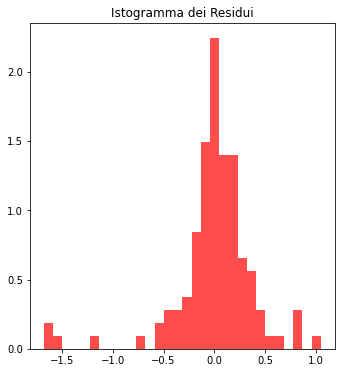

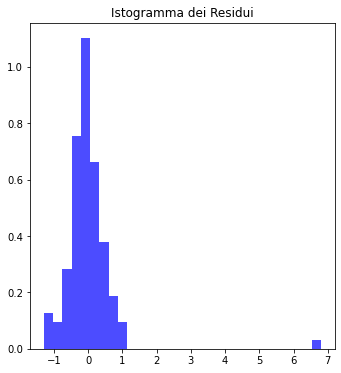

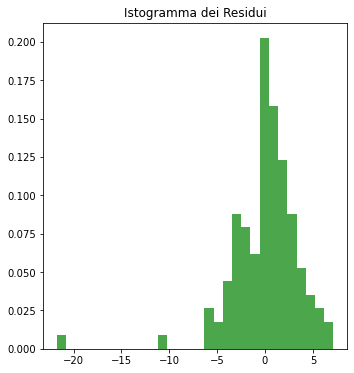

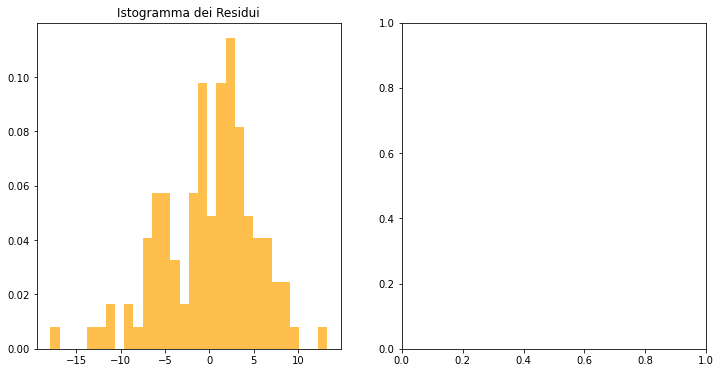

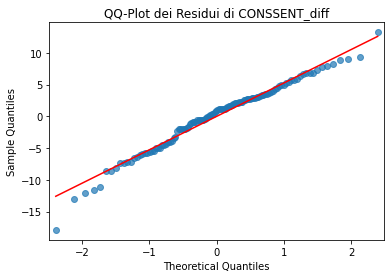

In [48]:
residui = results.resid

jb_test_stat, jb_p_value, _, _ = jarque_bera(residui['FED_RATE_diff'])

print("Test di Jarque-Bera per residui FED_RATE_diff:")
print(f"Statistica del test: {jb_test_stat}")
print(f"P-value: {jb_p_value}")
print("")

jb_test_stat, jb_p_value, _, _ = jarque_bera(residui['USURTOT'])


print("Test di Jarque-Bera per residui USURTOT:")
print(f"Statistica del test: {jb_test_stat}")
print(f"P-value: {jb_p_value}")
print("")

jb_test_stat, jb_p_value, _, _ = jarque_bera(residui['GDP QoQ'])


print("Test di Jarque-Bera per residui GDP QoQ:")
print(f"Statistica del test: {jb_test_stat}")
print(f"P-value: {jb_p_value}")
print("")

jb_test_stat, jb_p_value, _, _ = jarque_bera(residui['CONSSENT_diff'])

print("Test di Jarque-Bera per residui CONSSENT_diff:")
print(f"Statistica del test: {jb_test_stat}")
print(f"P-value: {jb_p_value}")

# Istogramma dei residui
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(residui['FED_RATE_diff'], bins=30, density=True, color='red', alpha=0.7)
plt.title('Istogramma dei Residui')


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(residui['USURTOT'], bins=30, density=True, color='blue', alpha=0.7)
plt.title('Istogramma dei Residui')


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(residui['GDP QoQ'], bins=30, density=True, color='green', alpha=0.7)
plt.title('Istogramma dei Residui')


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(residui['CONSSENT_diff'], bins=30, density=True, color='orange', alpha=0.7)
plt.title('Istogramma dei Residui')


# QQ-plot dei residui
plt.subplot(1, 2, 2)
qqplot(residui['CONSSENT_diff'], line='s', color='red', alpha=0.7)
plt.title('QQ-Plot dei Residui di CONSSENT_diff')

#plt.subplot(1, 2, 2)
#qqplot(residui['USURTOT'], line='s', color='blue', alpha=0.7)
#plt.title('QQ-Plot dei Residui')

#plt.subplot(1, 2, 2)
#qqplot(residui['GDP QoQ'], line='s', color='green', alpha=0.7)
#plt.title('QQ-Plot dei Residui')

#plt.subplot(1, 2, 2)
#qqplot(residui['CONSSENT_diff'], line='s', color='orange', alpha=0.7)
#plt.title('QQ-Plot dei Residui')

Si effettua test ADF sui residui per verificarne la stazionarietà

In [49]:

print("ADF TEST per FED_RATE_diff")
adf_test_stat, adf_p_value, _, _, adf_critical_values, _ = adfuller(residui['FED_RATE_diff'])
print(f"Statistica del test ADF: {adf_test_stat}")
print(f"P-value ADF: {adf_p_value}")
print(f"Valori critici ADF: {adf_critical_values}")
print("")
print("ADF TEST per USURTOT")
adf_test_stat, adf_p_value, _, _, adf_critical_values, _ = adfuller(residui['USURTOT'])
print(f"Statistica del test ADF: {adf_test_stat}")
print(f"P-value ADF: {adf_p_value}")
print(f"Valori critici ADF: {adf_critical_values}")
print("")
print("ADF TEST per GDP QoQ")
adf_test_stat, adf_p_value, _, _, adf_critical_values, _ = adfuller(residui['GDP QoQ'])
print(f"Statistica del test ADF: {adf_test_stat}")
print(f"P-value ADF: {adf_p_value}")
print(f"Valori critici ADF: {adf_critical_values}")
print("")
print("ADF TEST per CONSSENT_diff")
adf_test_stat, adf_p_value, _, _, adf_critical_values, _ = adfuller(residui['CONSSENT_diff'])
print(f"Statistica del test ADF: {adf_test_stat}")
print(f"P-value ADF: {adf_p_value}")
print(f"Valori critici ADF: {adf_critical_values}")

ADF TEST per FED_RATE_diff
Statistica del test ADF: -10.977266147540577
P-value ADF: 7.614018360324796e-20
Valori critici ADF: {'1%': -3.487517288664615, '5%': -2.8865777180380032, '10%': -2.5801239192052012}

ADF TEST per USURTOT
Statistica del test ADF: -11.061715135071685
P-value ADF: 4.7910831723259127e-20
Valori critici ADF: {'1%': -3.487517288664615, '5%': -2.8865777180380032, '10%': -2.5801239192052012}

ADF TEST per GDP QoQ
Statistica del test ADF: -11.411102452181538
P-value ADF: 7.247044504760622e-21
Valori critici ADF: {'1%': -3.487517288664615, '5%': -2.8865777180380032, '10%': -2.5801239192052012}

ADF TEST per CONSSENT_diff
Statistica del test ADF: -10.606799018581492
P-value ADF: 5.973789126367326e-19
Valori critici ADF: {'1%': -3.487517288664615, '5%': -2.8865777180380032, '10%': -2.5801239192052012}


Si effettua test di Ljung-Box per verificare presenza di autocorrelazione nei residui

Ljung Box residui FED_RATE_diff:
     lb_stat  lb_pvalue
10  4.946531   0.894721

Ljung Box residui USURTOT:
     lb_stat  lb_pvalue
10  3.028543   0.980744

Ljung Box residui GDP QoQ:
     lb_stat  lb_pvalue
10  3.263905   0.974514

Ljung Box residui CONSSENT_diff:
     lb_stat  lb_pvalue
10  4.063199   0.944451



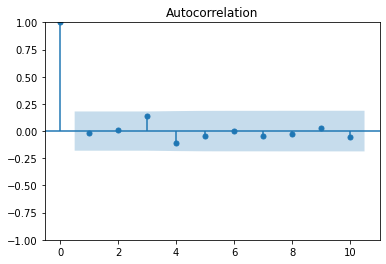

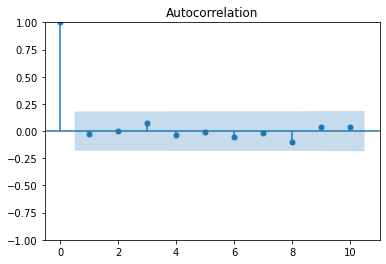

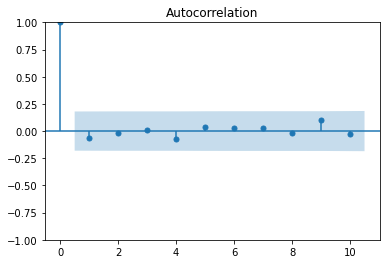

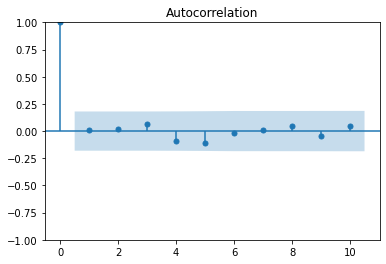

In [50]:
print("Ljung Box residui FED_RATE_diff:")
print(sm.stats.diagnostic.acorr_ljungbox(residui['FED_RATE_diff'], lags=[10]))
print("")

print("Ljung Box residui USURTOT:")
print(sm.stats.diagnostic.acorr_ljungbox(residui['USURTOT'], lags=[10]))
print("")

print("Ljung Box residui GDP QoQ:")
print(sm.stats.diagnostic.acorr_ljungbox(residui['GDP QoQ'], lags=[10]))
print("")

print("Ljung Box residui CONSSENT_diff:")
print(sm.stats.diagnostic.acorr_ljungbox(residui['CONSSENT_diff'], lags=[10]))
print("")

# grafico delle autocorrelazioni
sm.graphics.tsa.plot_acf(residui['FED_RATE_diff'], lags=10)
plt.show()

sm.graphics.tsa.plot_acf(residui['USURTOT'], lags=10)
plt.show()

sm.graphics.tsa.plot_acf(residui['GDP QoQ'], lags=10)
plt.show()

sm.graphics.tsa.plot_acf(residui['CONSSENT_diff'], lags=10)
plt.show()

Codice per predizione in caso di modello VARMA

In [52]:
#n_forecast = 4  # Imposta il numero di periodi da prevedere (nel tuo caso, 4)
#predict = results.get_prediction(start=len(train_df), end=len(train_df) + n_forecast - 1)
#predictions = predict.predicted_mean
#print(predictions)

Predizioni in caso di modello VAR

In [53]:
forecast = results.forecast(results.endog, steps=4)

print("Predizioni:")
forecast = pd.DataFrame(forecast)
df_forecast = pd.DataFrame(forecast[0])
Forecast = {'Data': [#'31-12-2018','29-03-2019','28-06-2019'],
                     #'30-09-2019','31-12-2019','31-03-2020',
                     #'30-06-2020','30-09-2020','31-12-2020',
                     #'31-03-2021','30-06-2021','30-09-2021',
                    # '31-12-2021','31-03-2022','30-06-2022',
                     #'2022-09-30',
                    #'2022-12-30', '2023-03-31','2023-06-30', '2023-09-29'],
                    '2023-12-29', '2024-03-29 ','2024-06-28', '2024-09-30'],
                    'FED_RATE_forecast' : forecast[0]
             }
Forecast = pd.DataFrame(Forecast)
Forecast['Data'] = pd.to_datetime(Forecast['Data'])
Forecast.set_index('Data', inplace=True)
print(Forecast)


GDP_input = test_df[['FED_RATE_diff']].copy() 
GDP_prediction = Forecast['FED_RATE_forecast']

df = pd.concat([GDP_input, GDP_prediction], axis=1)
df = pd.DataFrame(df)
nuovi_nomi_colonne = ['FedRate_Input', 'FedRate_prediction']
df.columns = nuovi_nomi_colonne
df

Predizioni:
            FED_RATE_forecast
Data                         
2023-12-29           0.083493
2024-03-29           0.039106
2024-06-28          -0.016278
2024-09-30          -0.033937


,FedRate_Input,FedRate_prediction
1993-12-31,0.00,NaN
1994-03-31,0.50,NaN
1994-06-30,0.75,NaN
1994-09-30,0.50,NaN
1994-12-30,0.75,NaN
...,...,...
2023-09-29,0.25,NaN
2023-12-29,NaN,0.083493
2024-03-29,NaN,0.039106
2024-06-28,NaN,-0.016278


Grafico delle predizioni

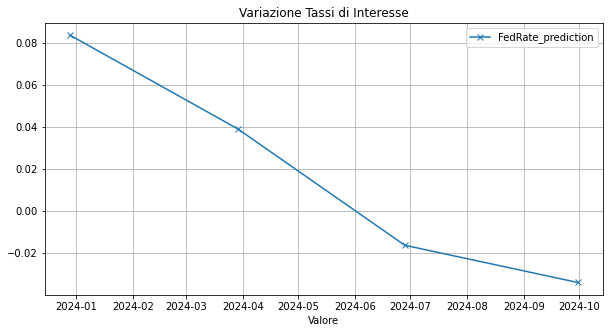

In [54]:
plt.figure(figsize=(10,5))
#plt.plot(df['GDP_input'], label='GDP_input', marker='o', linestyle='-')
plt.plot(Forecast, label='FedRate_prediction', marker='x', linestyle='-')
plt.xlabel('Indice')
plt.xlabel('Valore')
plt.legend()

plt.title('Variazione Tassi di Interesse')
plt.grid(True)
plt.show()

Calcolo di intervallo di confidenza delle predizioni

In [55]:
df['residuals'] = df['FedRate_Input'] - df['FedRate_prediction']
SE = np.std(df['residuals'])
valore_critico = 1.65

df['upper_bound'] = df['FedRate_prediction'] + (valore_critico*SE)
df['lower_bound'] = df['FedRate_prediction'] - (valore_critico*SE)

In [59]:
pred_int_1 = df.loc['2023-12-29','FedRate_prediction'] + macro_data.loc['2023-09-29','FED_RATE']
pred_int_2 = (df.loc['2024-03-29','FedRate_prediction']) + pred_int_1 
pred_int_3 = df.loc['2024-06-28','FedRate_prediction'] + pred_int_2 
pred_int_4 = df.loc['2024-09-30','FedRate_prediction'] + pred_int_3 
pred_integrate = {'FedRate_prediction_integrate':[pred_int_1,pred_int_2,pred_int_3,pred_int_4]}
df_integrato = pd.DataFrame(pred_integrate)

SE = df_integrato['FedRate_prediction_integrate'].std()/math.sqrt(4)
df_integrato['upper_bound'] = df_integrato['FedRate_prediction_integrate'] + (1.645*SE)
df_integrato['lower_bound'] = df_integrato['FedRate_prediction_integrate'] - (1.645*SE)
df_integrato

integrato = {'Data': ['2022-12-30', '2023-03-31','2023-06-30', '2023-09-29'],
                    'FedRate_prediction' : df_integrato['FedRate_prediction_integrate'], 
                     'upper_bound' : df_integrato['upper_bound'],
                     'lower_bound' : df_integrato['lower_bound']
            }
integrato = pd.DataFrame(integrato)
integrato = integrato.set_index('Data')
integrato

,FedRate_prediction,upper_bound,lower_bound
Data,,,
2022-12-30,5.583493,5.602055,5.564930
2023-03-31,5.622599,5.641161,5.604036
2023-06-30,5.606321,5.624884,5.587759
2023-09-29,5.572384,5.590947,5.553822


In [60]:
FED_RATE_input = macro_data['FED_RATE']
FED_RATE_input = pd.DataFrame(FED_RATE_input)
FED_RATE_input

integrato['FedRate_input'] = FED_RATE_input['FED_RATE'].tail(4)
integrato

,FedRate_prediction,upper_bound,lower_bound,FedRate_input
Data,,,,
2022-12-30,5.583493,5.602055,5.564930,4.50
2023-03-31,5.622599,5.641161,5.604036,5.00
2023-06-30,5.606321,5.624884,5.587759,5.25
2023-09-29,5.572384,5.590947,5.553822,5.50


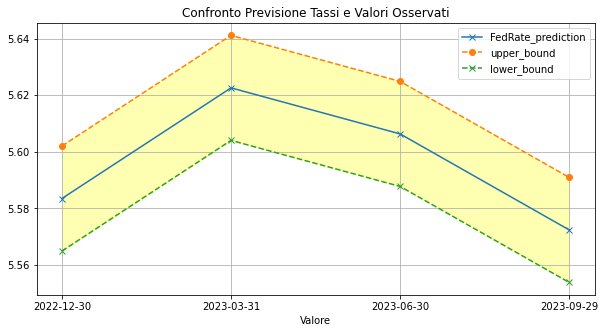

In [62]:
plt.figure(figsize=(10,5))
plt.plot(integrato['FedRate_prediction'], label='FedRate_prediction', marker='x', linestyle='-')
plt.plot(integrato['upper_bound'], label='upper_bound', marker='o', linestyle='--')
plt.plot(integrato['lower_bound'], label='lower_bound', marker='x', linestyle='--')
plt.xlabel('Indice')
plt.xlabel('Valore')
plt.legend()
plt.fill_between(integrato['FedRate_prediction'].index,integrato['upper_bound'],integrato['lower_bound'], color='yellow', alpha=0.3, label='Intervallo di confidenza')

plt.title('Confronto Previsione Tassi e Valori Osservati')
plt.grid(True)
plt.show()